In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
posts_segmented = pd.read_csv("/content/posts.csv")
posts_segmented.head()

,Unnamed: 0,title,id,score,url,num_comments,body,date,nsfw,sticky_post,flair-text,upvote_ratio
0,0,"POKHARA, LAKESIDE - Mahaseer cafe",fnztjy,4950,https://i.redd.it/f62x1h8x5ko41.jpg,156,NaN,2020-03-24 05:41:18,False,False,NaN,0.99
1,1,minimalism was made in Nepal,ogolge,1355,https://i.redd.it/iuvt1y6uc4a71.png,55,NaN,2021-07-09 05:01:56,False,False,Humor/हाँस्य,0.99
2,2,Never been on a Plane and a friend sent this,shqno2,1195,https://i.redd.it/4434gi71u6f81.jpg,74,NaN,2022-02-01 09:09:36,False,False,Society/समाज,0.99
3,3,This video made my day!!! I dont know if this ...,xlldxp,1121,https://v.redd.it/57cpn4revip91,48,NaN,2022-09-23 02:48:58,False,False,NaN,0.99
4,4,My take on Nepali Lo-Fi girl daylight version,iossvg,1052,https://i.redd.it/sin7nnx55xl51.png,106,NaN,2020-09-08 12:39:41,False,False,Art/कला,0.99


In [6]:
#Removing all null titles
posts_segmented.dropna(subset=['title'])
posts_segmented.head()


,Unnamed: 0,title,id,score,url,num_comments,body,date,nsfw,sticky_post,flair-text,upvote_ratio
0,0,"POKHARA, LAKESIDE - Mahaseer cafe",fnztjy,4950,https://i.redd.it/f62x1h8x5ko41.jpg,156,NaN,2020-03-24 05:41:18,False,False,NaN,0.99
1,1,minimalism was made in Nepal,ogolge,1355,https://i.redd.it/iuvt1y6uc4a71.png,55,NaN,2021-07-09 05:01:56,False,False,Humor/हाँस्य,0.99
2,2,Never been on a Plane and a friend sent this,shqno2,1195,https://i.redd.it/4434gi71u6f81.jpg,74,NaN,2022-02-01 09:09:36,False,False,Society/समाज,0.99
3,3,This video made my day!!! I dont know if this ...,xlldxp,1121,https://v.redd.it/57cpn4revip91,48,NaN,2022-09-23 02:48:58,False,False,NaN,0.99
4,4,My take on Nepali Lo-Fi girl daylight version,iossvg,1052,https://i.redd.it/sin7nnx55xl51.png,106,NaN,2020-09-08 12:39:41,False,False,Art/कला,0.99


In [7]:
# Pre-processing the comments to acheive the following points:
#   1. Removing the URLs using standard patterns like https, http, r/
#   2. Removing special characters other than periods and commas
#   3. Converting into lowercase
#   4. Only handling the english comments using ASCII range
#   5. Removing any characters that are not word characters, spaces or periods
#   6. Removing any extra spaces between two words
for index, row in posts_segmented.iterrows():
    text = row["title"]
    url_pattern = r'https\S*|http\S*|www\.\S*|r/\S*'
    cleaned = re.sub(url_pattern, r'', text)
    cleaned = re.sub(r'[?|!|\'|"|#|%|$|@|*|(|)|\-|_|=|+]', r' ', cleaned)
    cleaned = cleaned.lower()
    cleaned = re.sub(r'[^\x00-\x7F]+', ' ', cleaned)
    cleaned = re.sub(r'(?<!\d)\.(?!\d)', ' ', cleaned)  # This preserves only decimal points
    cleaned = re.sub(r'[^\w\s.]', ' ', cleaned)
    cleaned = ' '.join(cleaned.split())
    posts_segmented.at[index, "title"] = cleaned


#posts_segmented

In [11]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN if no specific tag is found

for index, row in posts_segmented.iterrows():
    text = row["title"]
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(filtered_tokens)
    # Lemmatization with POS tagging
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag))
                     for token, pos_tag in pos_tags]
    processed_comment = ' '.join(lemmatized_tokens)
    posts_segmented.at[index, "title"] = processed_comment

#posts_segmented

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


EDA

In [12]:
posts_segmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    100 non-null    int64  
 1   title         100 non-null    object 
 2   id            100 non-null    object 
 3   score         100 non-null    int64  
 4   url           100 non-null    object 
 5   num_comments  100 non-null    int64  
 6   body          3 non-null      object 
 7   date          100 non-null    object 
 8   nsfw          100 non-null    bool   
 9   sticky_post   100 non-null    bool   
 10  flair-text    85 non-null     object 
 11  upvote_ratio  100 non-null    float64
dtypes: bool(2), float64(1), int64(3), object(6)
memory usage: 8.1+ KB


In [13]:
posts_segmented.describe()

,Unnamed: 0,score,num_comments,upvote_ratio
count,100.000000,100.000000,100.000000,100.000000
mean,49.500000,781.120000,72.040000,0.987700
std,29.011492,448.948655,61.818882,0.011088
min,0.000000,583.000000,16.000000,0.940000
25%,24.750000,614.500000,38.000000,0.980000
50%,49.500000,683.500000,54.500000,0.990000
75%,74.250000,844.750000,86.000000,0.990000
max,99.000000,4950.000000,490.000000,1.000000


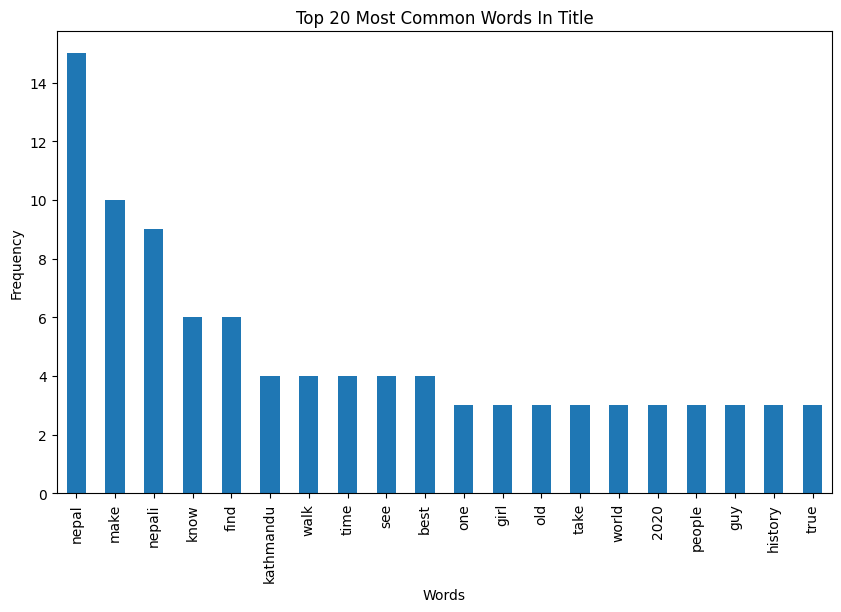

In [14]:
# Word Frequency Analysis
word_freq = pd.Series(' '.join(posts_segmented['title']).split()).value_counts()
#print(word_freq)
word_freq[:20].plot(kind='bar', figsize=(10, 6))
plt.title('Top 20 Most Common Words In Title')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [15]:
print("Number of Distinct words in the entire corpus: ", len(word_freq))

Number of Distinct words in the entire corpus:  420


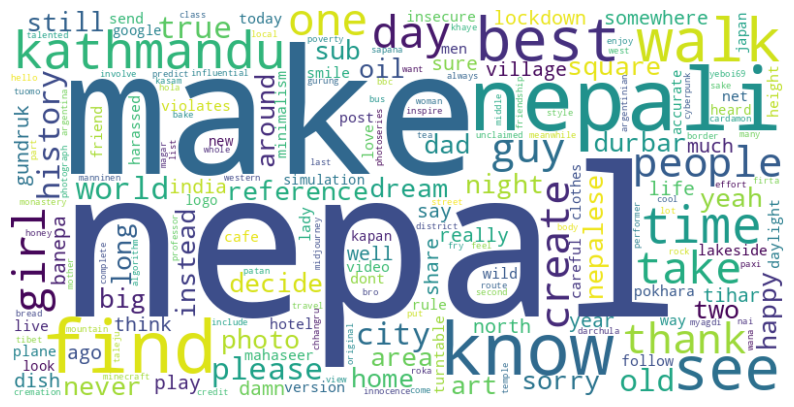

In [16]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(posts_segmented['title']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

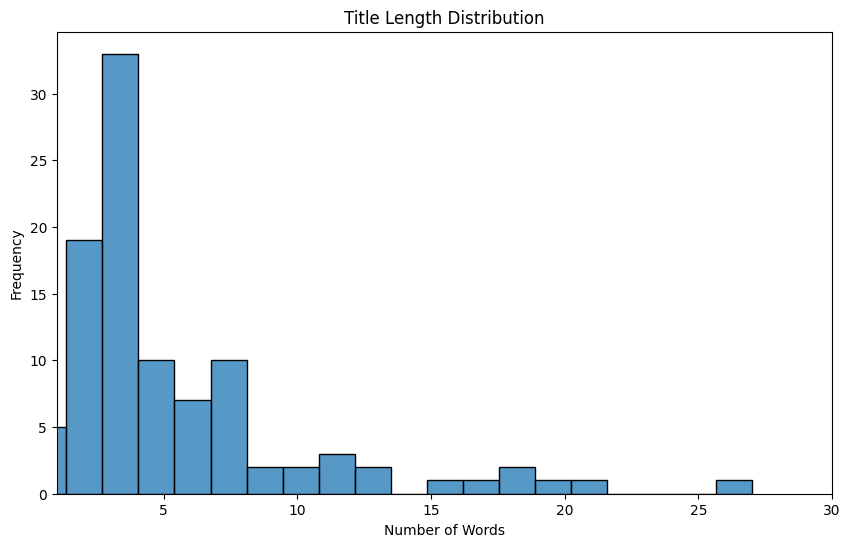

In [17]:
# Comment Length Distribution
posts_segmented['title_length'] = posts_segmented['title'].apply(lambda x: len(x.split()))
plt.figure(figsize = (10,6))
sns.histplot(data=posts_segmented, x='title_length', bins=20)
plt.title('Title Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(xmin=1, xmax = 30)
plt.show()

In [18]:
posts_segmented

,Unnamed: 0,title,id,score,url,num_comments,body,date,nsfw,sticky_post,flair-text,upvote_ratio,title_length
0,0,pokhara lakeside mahaseer cafe,fnztjy,4950,https://i.redd.it/f62x1h8x5ko41.jpg,156,NaN,2020-03-24 05:41:18,False,False,NaN,0.99,4
1,1,minimalism make nepal,ogolge,1355,https://i.redd.it/iuvt1y6uc4a71.png,55,NaN,2021-07-09 05:01:56,False,False,Humor/हाँस्य,0.99,3
2,2,never plane friend send,shqno2,1195,https://i.redd.it/4434gi71u6f81.jpg,74,NaN,2022-02-01 09:09:36,False,False,Society/समाज,0.99,4
3,3,video make day dont know post violates rule,xlldxp,1121,https://v.redd.it/57cpn4revip91,48,NaN,2022-09-23 02:48:58,False,False,NaN,0.99,8
4,4,take nepali girl daylight version,iossvg,1052,https://i.redd.it/sin7nnx55xl51.png,106,NaN,2020-09-08 12:39:41,False,False,Art/कला,0.99,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,hai tihar aayo,js8u63,592,https://i.redd.it/ilnllxnycmy51.jpg,37,NaN,2020-11-11 14:14:29,False,False,Humor/हाँस्य,0.99,3
96,96,lmfao find gem,pukmb2,585,https://i.redd.it/gxfllcj5acp71.jpg,36,NaN,2021-09-24 14:11:55,False,False,Humor/हाँस्य,0.99,3
97,97,old house digital draw december 2020,klojao,583,https://i.redd.it/ex16558usw761.jpg,32,NaN,2020-12-28 11:03:47,False,False,Art/कला,1.00,6
98,98,city dream nepali girl,jqpotl,587,https://i.imgur.com/PjibmOO.jpg,31,NaN,2020-11-09 03:06:29,False,False,NaN,0.99,4


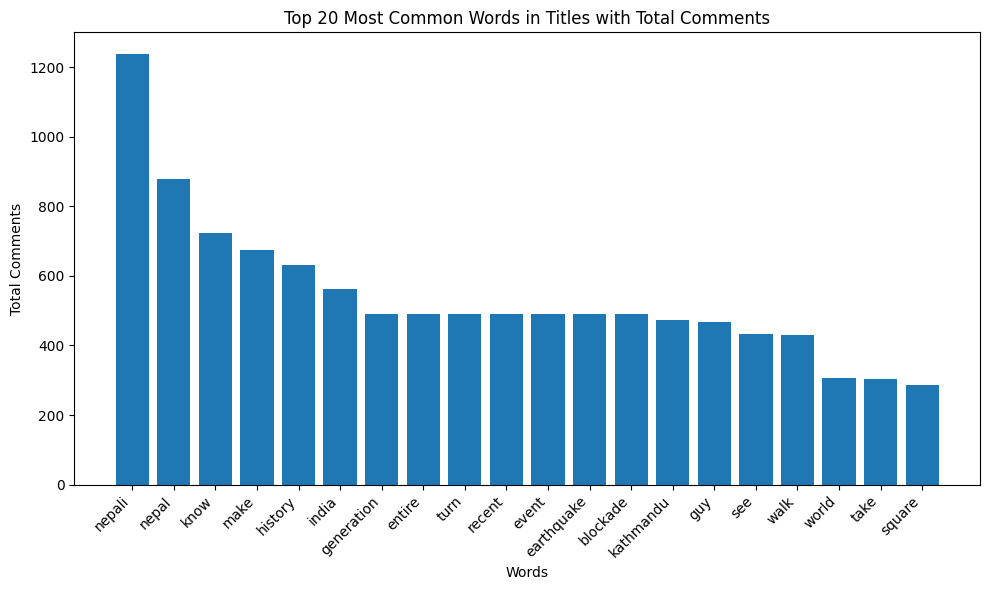

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {'title': posts_segmented['title'],
        'comment_numbers': posts_segmented['num_comments']}

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate word frequencies
word_freq = pd.Series(' '.join(df['title']).split()).value_counts()

# Create a new DataFrame for words and their corresponding total comment numbers
word_comment_df = pd.DataFrame({'word': word_freq.index, 'total_comments': 0})

# Calculate the total comments for each word
for index, row in df.iterrows():
    for word in row['title'].split():
        if word in word_comment_df['word'].values:
            word_comment_df.loc[word_comment_df['word'] == word, 'total_comments'] += row['comment_numbers']

# Sort the DataFrame by word frequencies and select the top 20 words
top_20_words = word_comment_df.sort_values(by='total_comments', ascending=False).head(20)

# Plot the top 20 words and their total comment numbers
plt.figure(figsize=(10, 6))
plt.bar(top_20_words['word'], top_20_words['total_comments'])
plt.title('Top 20 Most Common Words in Titles with Total Comments')
plt.xlabel('Words')
plt.ylabel('Total Comments')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [20]:
#Adjusting Non English Scripts
posts_segmented['flair-text'] = posts_segmented['flair-text'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else x)

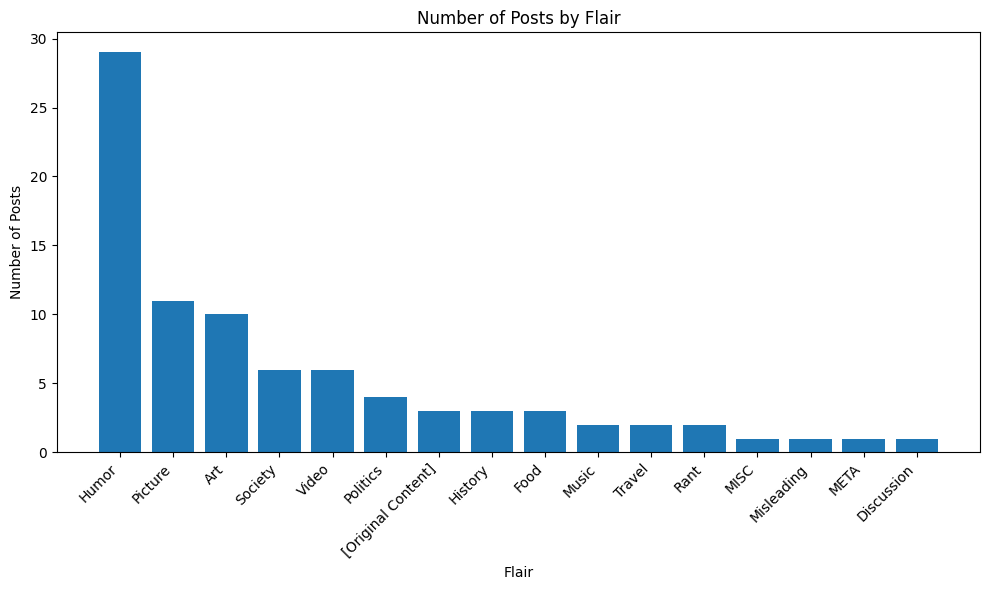

In [21]:
data = {'title': posts_segmented['title'],
        'flair': posts_segmented['flair-text']}
df = pd.DataFrame(data)

# Count the number of posts for each flair
flair_counts = df['flair'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(flair_counts.index, flair_counts.values)
plt.title('Number of Posts by Flair')
plt.xlabel('Flair')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


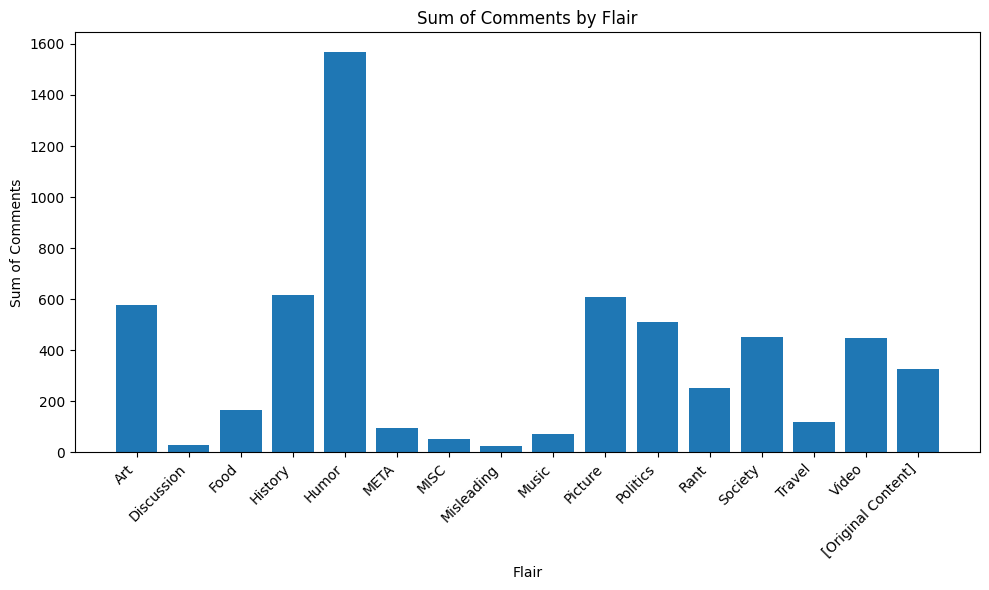

In [22]:
data = {'title': posts_segmented['title'],
        'flair': posts_segmented['flair-text'],
        'comments': posts_segmented['num_comments']}
df = pd.DataFrame(data)

# Group the data by 'flair' and calculate the sum of total upvotes for each flair
flair_upvotes = df.groupby('flair')['comments'].sum()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(flair_upvotes.index, flair_upvotes.values)
plt.title('Sum of Comments by Flair')
plt.xlabel('Flair')
plt.ylabel('Sum of Comments')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


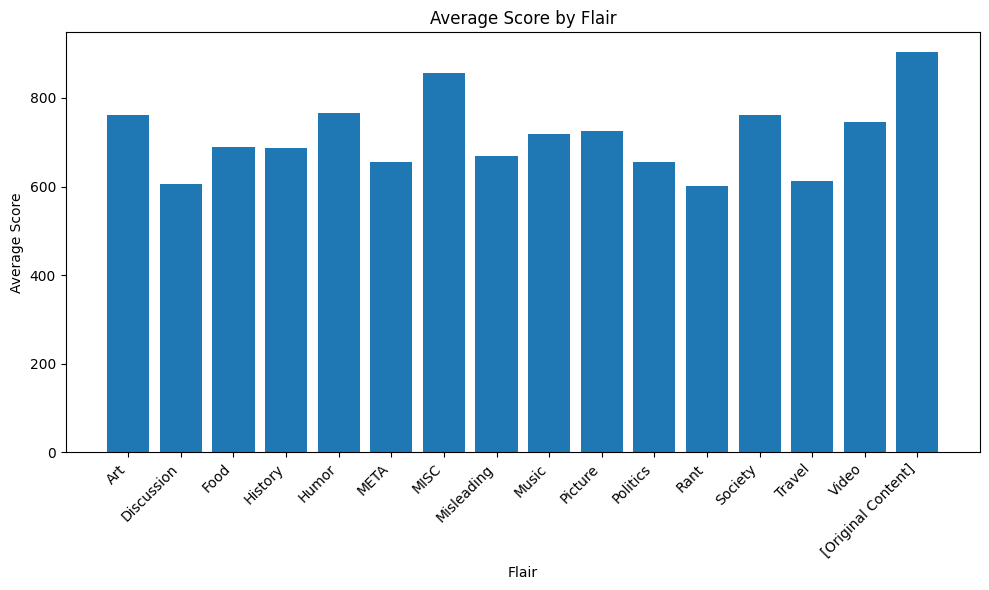

In [23]:
data = {'title': posts_segmented['title'],
        'flair': posts_segmented['flair-text'],
        'score': posts_segmented['score']}
df = pd.DataFrame(data)

# Group the data by 'flair' and calculate the average total upvotes for each flair
flair_avg_upvotes = df.groupby('flair')['score'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(flair_avg_upvotes.index, flair_avg_upvotes.values)
plt.title('Average Score by Flair')
plt.xlabel('Flair')
plt.ylabel('Average Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


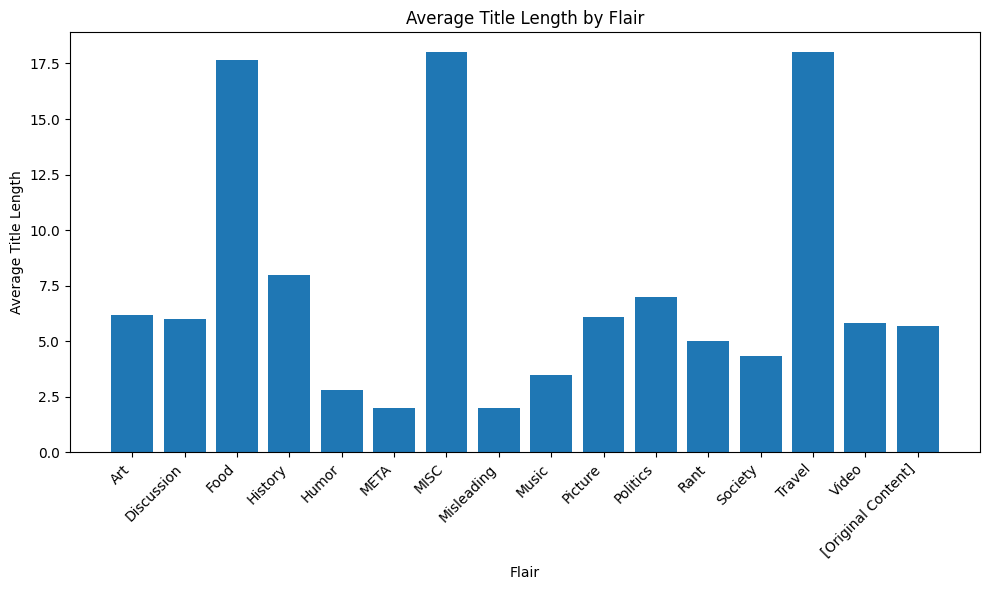

In [24]:
data = {'title': posts_segmented['title'],
        'flair': posts_segmented['flair-text'],
        'title_length': posts_segmented['title_length']}
df = pd.DataFrame(data)

# Group the data by 'flair' and calculate the average total upvotes for each flair
flair_avg_upvotes = df.groupby('flair')['title_length'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(flair_avg_upvotes.index, flair_avg_upvotes.values)
plt.title('Average Title Length by Flair')
plt.xlabel('Flair')
plt.ylabel('Average Title Length')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

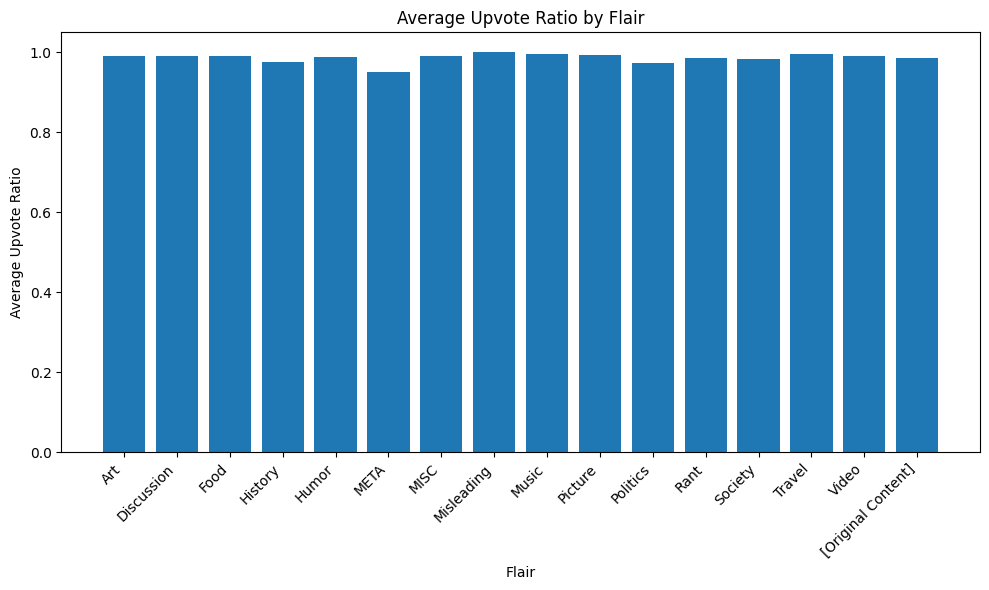

In [25]:
data = {'title': posts_segmented['title'],
        'flair': posts_segmented['flair-text'],
        'upvote': posts_segmented['upvote_ratio']}
df = pd.DataFrame(data)

# Group the data by 'flair' and calculate the average total upvotes for each flair
flair_avg_upvotes = df.groupby('flair')['upvote'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(flair_avg_upvotes.index, flair_avg_upvotes.values)
plt.title('Average Upvote Ratio by Flair')
plt.xlabel('Flair')
plt.ylabel('Average Upvote Ratio')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


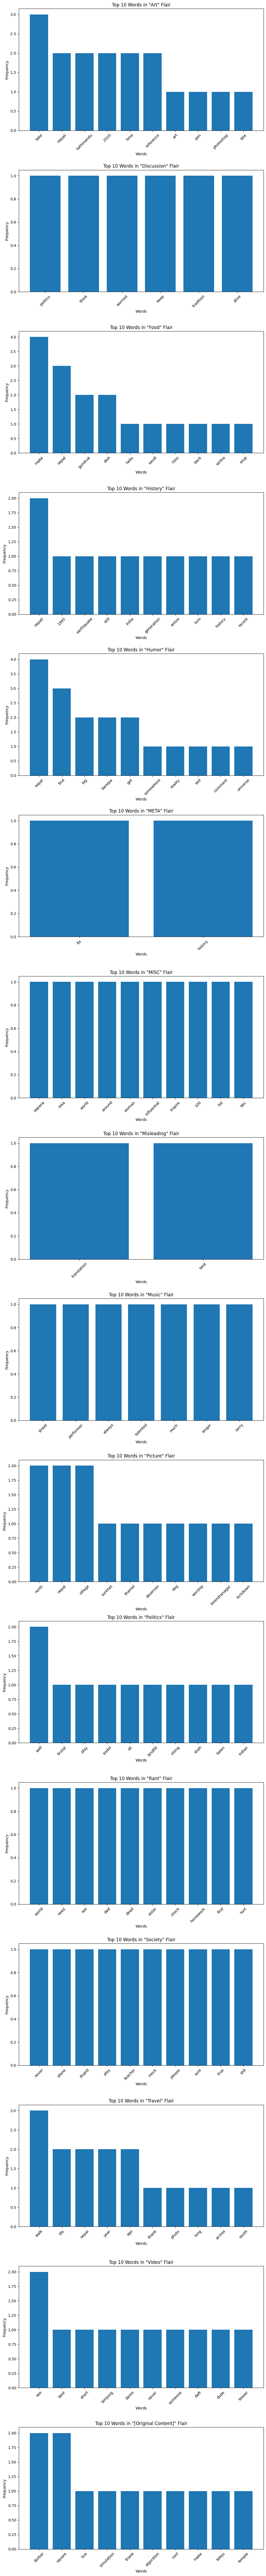

In [26]:
data = {'title': posts_segmented['title'],
        'flair': posts_segmented['flair-text']}
df = pd.DataFrame(data)

# Group the data by 'flair' column
grouped = df.groupby('flair')

# Create subplots for each flair
fig, axs = plt.subplots(len(grouped), figsize=(10, 6 * len(grouped)))

# Iterate through each flair group
for i, (flair, group) in enumerate(grouped):
    # Calculate word frequencies for titles within this flair
    word_freq = pd.Series(' '.join(group['title']).split()).value_counts()

    # Select the top 10 words
    top_10_words = word_freq.head(10)

    # Plot a histogram for this flair
    axs[i].bar(top_10_words.index, top_10_words.values)
    axs[i].set_title(f'Top 10 Words in "{flair}" Flair')
    axs[i].set_xlabel('Words')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [27]:
posts_segmented[posts_segmented['sticky_post'] == 'True']

,Unnamed: 0,title,id,score,url,num_comments,body,date,nsfw,sticky_post,flair-text,upvote_ratio,title_length
